In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Loading and displaying the outlier removed dataset

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('../data/processed/2_outlier_removed_features.csv')

# 1.Labelling the Dataset Using Domain Knowlege

As we don't have labelled data, the only possibility is to use some features that would be indicative of class types we are trying to infer. Any field with items related to gender types could be a pontential indicator of gende types. Following are a set of such selected features. 

In [4]:
slc_clm = ['female_items', 'wacc_items', 'wapp_items', 'wftw_items', 'wspt_items', 'male_items', 'macc_items', 'mapp_items', 'mftw_items', 'mspt_items']
print(slc_clm)

['female_items', 'wacc_items', 'wapp_items', 'wftw_items', 'wspt_items', 'male_items', 'macc_items', 'mapp_items', 'mftw_items', 'mspt_items']


## 1.1 Correlation Analysis 

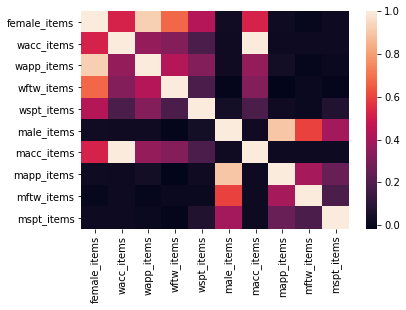

In [5]:
corr = df[ slc_clm ].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

The positive correllation between gender related items indicates that the assumption is valid. The items should be indicative of the gender. Interestingly, <b> macc_items or male accessories </b> goes more positively with women stuff purchasors. This could be due to female tendancy of buying them as gifts. Probably it would be better to remove "macc and wacc" items from the labelling process. 

In [6]:
slc_clm = ['female_items', 'wapp_items', 'wftw_items', 'wspt_items', 'male_items', 'mapp_items', 'mftw_items', 'mspt_items']

## 1.2.Plotting Selected Features to Identify Clusters

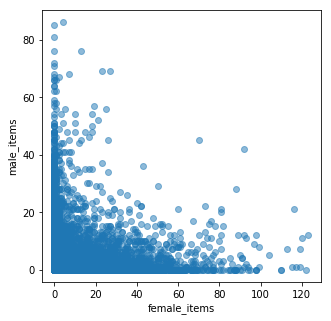

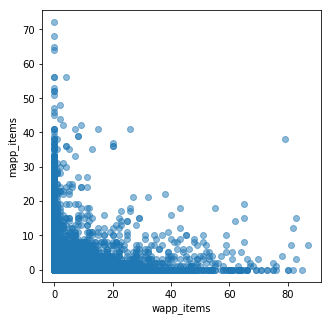

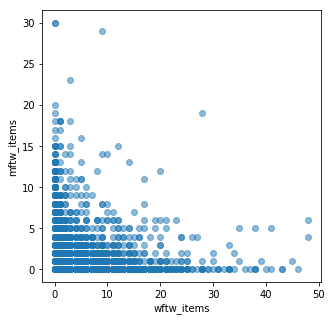

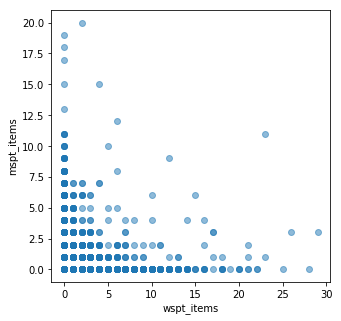

In [7]:
matplotlib.rcParams['figure.figsize'] = [5, 5]

for i in range(round(len(slc_clm)/2)):
    plt.scatter(df[ slc_clm[i] ].values, df[ slc_clm[i+round(len(slc_clm)/2)] ].values,alpha=0.5)
    plt.xlabel(slc_clm[i])
    plt.ylabel(slc_clm[i+round(len(slc_clm)/2)])
    plt.show()
    plt.close()


There aren't any significant clusters. Let's do a cluster analysis with K-means.

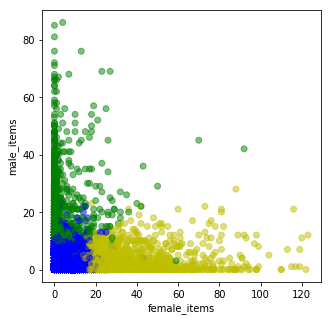

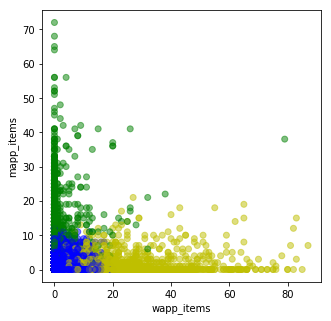

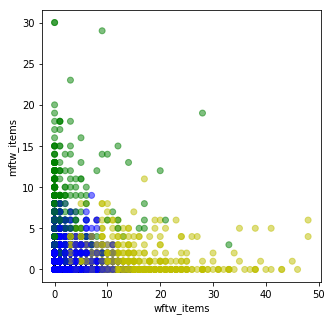

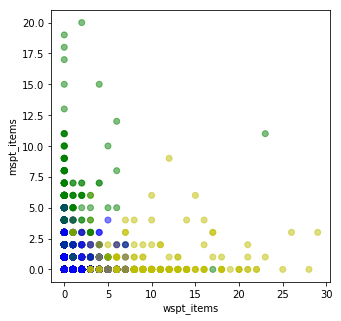

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as KM

import warnings
warnings.filterwarnings('ignore')


sc = StandardScaler()
values = sc.fit_transform(df[ slc_clm ].values)


km = KM(n_clusters=3, random_state=0, max_iter=1000).fit(values)
labels = km.predict(values)
labels = ['y' if x==0 else ('b' if x== 1 else 'g') for x in labels]

for i in range(round(len(slc_clm)/2)):
    plt.scatter(df[ slc_clm[i] ].values, df[ slc_clm[i+round(len(slc_clm)/2)] ].values,alpha=0.5, c=labels)
    plt.xlabel(slc_clm[i])
    plt.ylabel(slc_clm[i+round(len(slc_clm)/2)])
    plt.show()
    plt.close()

Now we can remove, middle cluster which is neighther male or female significantly

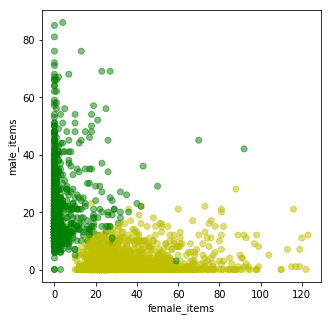

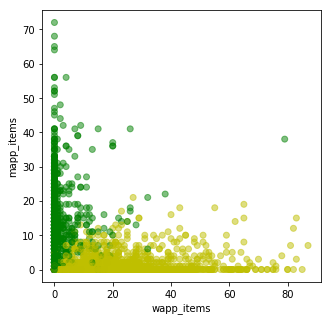

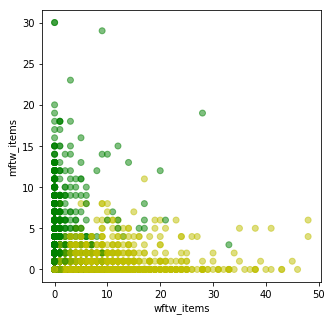

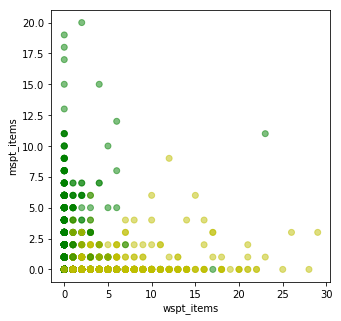

In [9]:
df_refined = df
df_refined['labels'] = labels
df_refined = df_refined[ df_refined['labels'] != 'b' ]

for i in range(round(len(slc_clm)/2)):
    plt.scatter(df_refined[ slc_clm[i] ].values, df_refined[ slc_clm[i+round(len(slc_clm)/2)] ].values,alpha=0.5, c=df_refined['labels'].values)
    plt.xlabel(slc_clm[i])
    plt.ylabel(slc_clm[i+round(len(slc_clm)/2)])
    plt.show()
    plt.close()

Selecting more discriminative features using this labelled data-set

In [10]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

scaler = StandardScaler()
values = scaler.fit_transform( df_refined.iloc[:,:-1].values )

X = values 
Y = df_refined['labels'].values

estimator = SVC(kernel="linear")

selector = RFE(estimator, 22, step=1)
selector = selector.fit(X, Y)

sig_cols = df_refined.columns[:-1][ selector.support_ ] 

for c in slc_clm:
    if c not in sig_cols:
        sig_cols.append(c)

print(sig_cols)

Index(['android_orders', 'average_discount_used', 'cancels', 'curvy_items',
       'desktop_orders', 'devices', 'female_items', 'macc_items', 'male_items',
       'mapp_items', 'mftw_items', 'msite_orders', 'mspt_items', 'orders',
       'parcelpoint_orders', 'paypal_payments', 'returns',
       'shipping_addresses', 'vouchers', 'wapp_items', 'wftw_items',
       'wspt_items'],
      dtype='object')


# 2.Second Stage of Clustering With New Columns

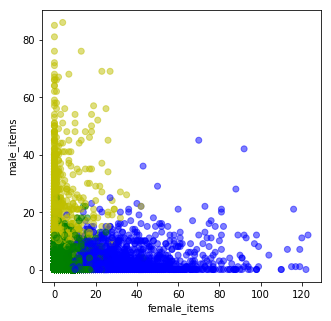

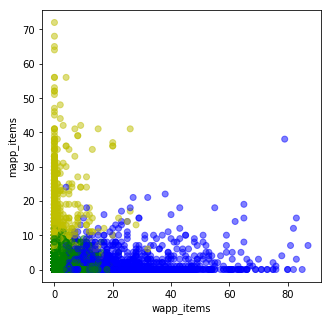

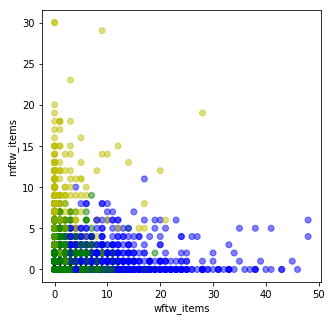

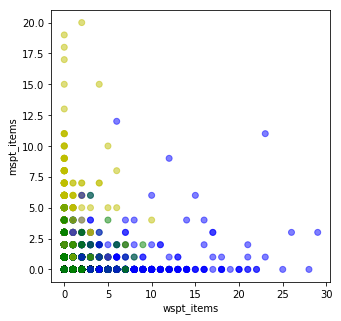

In [11]:
sc = StandardScaler()
values = sc.fit_transform(df[ sig_cols ].values)


km = KM(n_clusters=3, random_state=0, max_iter=1000).fit(values)
labels = km.predict(values)
labels = ['y' if x==0 else ('b' if x== 1 else 'g') for x in labels]

for i in range(round(len(slc_clm)/2)):
    plt.scatter(df[ slc_clm[i] ].values, df[ slc_clm[i+round(len(slc_clm)/2)] ].values,alpha=0.5, c=labels)
    plt.xlabel(slc_clm[i])
    plt.ylabel(slc_clm[i+round(len(slc_clm)/2)])
    plt.show()
    plt.close()

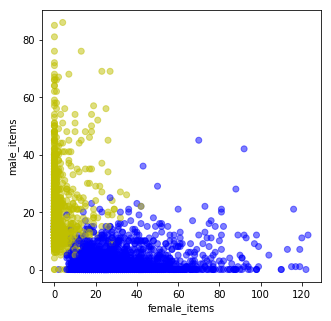

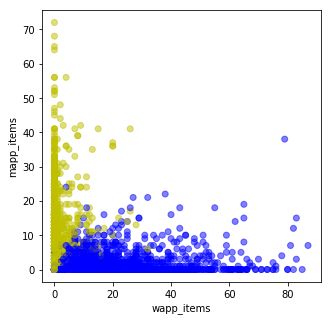

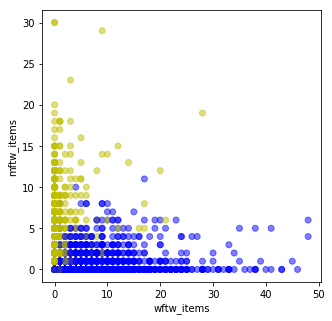

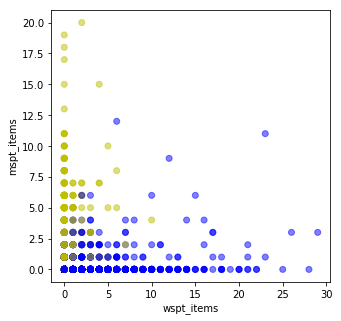

In [12]:
df_refined2 = df
df_refined2['labels'] = labels
df_refined2 = df_refined2[ df_refined2['labels'] != 'g' ]

#df_refined2['labels'] = df_refined2['labels'].map({0:'r',2:'y'})
df_refined2['gender'] = df_refined2['labels'].map({'y':'M','b':'F'})

for i in range(round(len(slc_clm)/2)):
    plt.scatter(df_refined2[ slc_clm[i] ].values, df_refined2[ slc_clm[i+round(len(slc_clm)/2)] ].values,alpha=0.5, c=df_refined2['labels'].values)
    plt.xlabel(slc_clm[i])
    plt.ylabel(slc_clm[i+round(len(slc_clm)/2)])
    plt.show()
    plt.close()

In [13]:
df_refined2.columns

Index(['afterpay_payments', 'android_orders', 'apple_payments',
       'average_discount_onoffer', 'average_discount_used', 'cancels',
       'cc_payments', 'curvy_items', 'days_since_last_order',
       'days_since_first_order', 'desktop_orders', 'devices',
       'different_addresses', 'female_items', 'home_orders', 'ios_orders',
       'is_newsletter_subscriber', 'items', 'macc_items', 'male_items',
       'mapp_items', 'mftw_items', 'msite_orders', 'mspt_items', 'orders',
       'other_collection_orders', 'parcelpoint_orders', 'paypal_payments',
       'redpen_discount_used', 'returns', 'revenue', 'sacc_items',
       'shipping_addresses', 'unisex_items', 'vouchers', 'wacc_items',
       'wapp_items', 'wftw_items', 'work_orders', 'wspt_items', 'labels',
       'gender'],
      dtype='object')

# 3.Third Stage Support Collection for the Final Neural Network

In [37]:
sc = StandardScaler()
values = sc.fit_transform(df_refined2.iloc[:,:-2].values)

X = values 
Y = df_refined2['labels'].values

estimator = SVC(kernel="linear")

selector = RFE(estimator, 30, step=1)
selector = selector.fit(X, Y)

sig_cols_final = df_refined2.columns[:-2][ selector.support_ ] 


#print(sig_cols)

#print(sig_cols_final)



In [38]:
training_dataset = df_refined2[ sig_cols_final ]
training_dataset['labels'] = df_refined2['labels']
training_dataset['gender'] = df_refined2['gender']
training_dataset.to_csv('../data/processed/3_training_labelled_set.csv', index=False)

In [39]:
df_refined2[df_refined2['gender'] == 'M'].shape

(1105, 42)

In [40]:
for c in sig_cols:
    if c not in sig_cols_final:
        print(c)

android_orders
average_discount_used
cancels
paypal_payments
